In [2]:
#import libraries
import os
import numpy as np
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt
from rasterio.plot import plotting_extent
import earthpy.plot as ep


In [3]:
folder_path = '../Dataset'

In [4]:
# Function to load raster and GeoJSON data
def load_data(folder):
    raster_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.tif')]
    
    geojson_file = os.path.join(folder, 'Change_Area.geojson') 
    
    rasters = [rioxarray.open_rasterio(raster_path, masked=True) for raster_path in raster_files]
    
    geojson = gpd.read_file(geojson_file)  
    
    return rasters, geojson

# Function to normalize a band
def normalize_band(band):
    """Normalize a single band of raster data."""
    band_min = band.min()
    band_max = band.max()
    
    if band_max > band_min: 
        normalized_band = (band - band_min) / (band_max - band_min) 
        return normalized_band
    else:
        return np.zeros_like(band)  
    
# Function to adjust contrast
def adjust_contrast(image, factor):
    """Adjust contrast of the image using a scaling factor."""
    mean = np.mean(image)
    adjusted = (image - mean) * factor + mean
    return np.clip(adjusted, 0,None)  


In [5]:
# Function to plot multiple raster images side by side
def plot_rasters_side_by_side(rasters, geojson, titles, brightness_factor=4, contrast_factor=2):

    fig, axes = plt.subplots(1, len(rasters), figsize=(15, 7)) 
    for i, raster in enumerate(rasters):
    
        plot_extent = plotting_extent(raster[0], raster.rio.transform())

        normalized_raster = np.clip(raster.values, 0, None) 
        normalized_raster = np.where(np.isnan(normalized_raster), 0, normalized_raster)  

        # Normalize each band individually
        for j in range(normalized_raster.shape[0]):
            normalized_raster[j] = normalize_band(normalized_raster[j])

        normalized_raster = np.clip(normalized_raster * brightness_factor, 0, 1)  

        # Adjust contrast
        for j in range(normalized_raster.shape[0]):
            normalized_raster[j] = adjust_contrast(normalized_raster[j], factor=contrast_factor)

        ep.plot_rgb(normalized_raster,
                    rgb=[3, 2, 1],  
                    ax=axes[i],
                    title=titles[i],
                    extent = plot_extent)

        # Overlay the GeoJSON polygons
        geojson.plot(ax=axes[i], edgecolor='red', facecolor='none', linewidth=2)

    plt.tight_layout()
    plt.show()


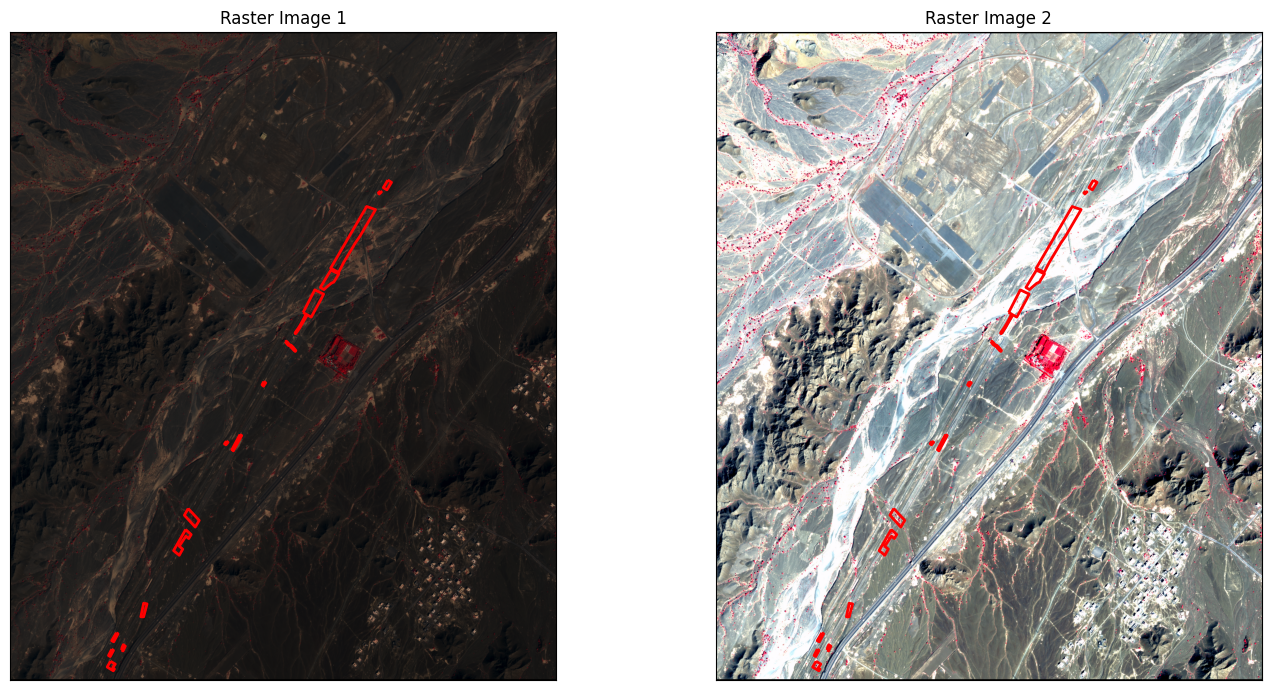

In [6]:
rasters, geojson = load_data(folder_path)

titles = [f"Raster Image {i + 1}" for i in range(len(rasters))]

plot_rasters_side_by_side(rasters, geojson, titles)
